### Test mutual information on Hawkes and Poisson Process Simulations

In [1]:
from sparse_discrete_table import SparseDiscreteTable, build_discrete_table
from ipywidgets import widgets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import plotly.graph_objects as go

In [2]:
def plot(y, x, mode='lines+markers'):
#     x = np.arange(len(y))
        
    data = [go.Scatter(x=x,y=y,mode=mode)]
    layout = dict(width=900,height=400)
    return go.FigureWidget(data=data, layout=layout)

In [3]:
def run_trails(fn, fn_kwargs, ntrails):
    trails = []
    for n in range(ntrails):
        obs = fn(**fn_kwargs)
        mi = gen_mi(obs)
        trails.append(mi)
    return trails

In [4]:
from tick.plot import plot_point_process
from tick.hawkes import SimuHawkes, HawkesKernelSumExp
from scipy.stats import poisson


def gen_hawkes(baseline, intensity, decay, run_time):
    hawkes = SimuHawkes(n_nodes=1, end_time=run_time, verbose=False, seed=np.random.randint(10**6))
    kernel = HawkesKernelSumExp(intensities=[.5], decays=[10], )
    hawkes.set_kernel(i=0, j=0, kernel=kernel)
    hawkes.set_baseline(i=0, baseline=.5)
    
    hawkes.simulate()
    timestamps = hawkes.timestamps
    
    hawkes_counts, _ = np.histogram(hawkes.timestamps,np.arange(0,run_time))
    return hawkes_counts

def gen_obs(k,mu,w,n):
    obs = []
    for i in range(n):
        lam = mu+k
        try:
            o = poisson.rvs(mu=lam,size=1)
            obs.append(o[0])
            k = k*(1-w) + o*(w)
        except ValueError as e:
            raise ValueError(f"{e} - lam={lam}")
            
    return obs


def gen_mi(obs, max_offset=30, norm=False):
    mis = []
    for t in range(1,max_offset):
        xy = np.stack([obs[t:], obs[:-t]], axis=1)
        dt = build_discrete_table(xy, ['x','y'])
        mi = dt.mutual_information(['x'], ['y'],norm)
    #     print(f"mi: {mi}")
        mis.append(mi)
    return mis

In [5]:
state = dict(
    baseline=0.5, 
    intensity=0.5, 
    decay=2, 
    run_time=1000,
)
    
y_hawkes = gen_hawkes(
    baseline=0.5, 
    intensity=0.5, 
    decay=2, 
    run_time=1000,
)
x_hawkes = np.arange(len(y_hawkes))
fig = plot(y=y_hawkes,x=x_hawkes) 

y_mi = gen_mi(y_hawkes, norm=True)
x_mi = np.arange(len(y_hawkes))    
fig_mi = plot(y=y_mi,x=x_mi) 
    
def hawkes_callback(change):
    global state, fig, fig_mi
    if isinstance(change, dict) and change['name'] == 'value':
        value = change['new']
        name = change['owner'].description
        state[name] = value
        
        y_hawkes = gen_hawkes(**state)
        x_hawkes = np.arange(len(y_hawkes))
        
        with fig.batch_update():
            fig.data[0].x = x_hawkes
            fig.data[0].y = y_hawkes
            
        y_mi = gen_mi(y_hawkes, max_offset=60, norm=True)
        x_mi = np.arange(len(y_mi))                        
        with fig_mi.batch_update():
            fig_mi.data[0].x = x_mi
            fig_mi.data[0].y = y_mi            

            
def new_sliders(state, callback_fn):
    sliders = []
    for k,v in state.items():        
        slider = widgets.FloatSlider(
            value=v,
            min=v,
            max=10*v,
            step=v,
            description=k,
            continuous_update=False,
        ) 
        slider.observe(callback_fn)
        sliders.append(slider)
    return sliders

sliders = new_sliders(state, hawkes_callback)

widgets.VBox([
    *sliders,
    fig_mi,
    fig,
])

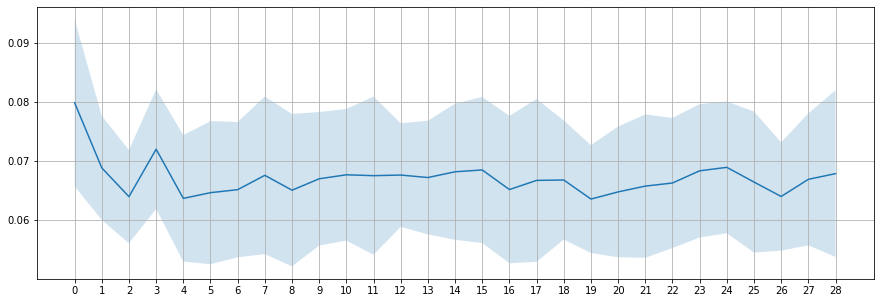

In [6]:
trails = run_trails(gen_hawkes, state, 20)
trails_mean = np.mean(trails,axis=0)
trails_std = np.std(trails,axis=0)
trails_x = np.arange(len(trails_mean))
plt.figure(figsize=(15,5))
plt.plot(trails_mean)
plt.fill_between(x=trails_x, y1=trails_mean-trails_std, y2=trails_mean+trails_std, alpha=0.2)
plt.grid()
plt.xticks(trails_x)
plt.show()